#  Taxi orders prediction

A Taxi company has collected historical data on taxi orders at the airports. The task is to predict the number of taxi orders for the next hour in order to attract more drivers during the peak hours. 

The metrics used is *RMSE*, the value on the test sample should not exceed 48. Test sample should be 10% of the original data.

### Contents:

<a href='#first'>1) Data preprocessing </a> <br/>
<a href='#second'>2) EDA</a> <br/>
<a href='#third'>3) Training the model</a> <br/>
<a href='#fourth'>4) Test </a> <br/>
<a href='#fifth'>5) Summary</a> <br/>

<a id='first'></a>
## 1. Data preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
data.sort_index(inplace=True)
data.info()
display(data.head())
data = data.resample('1H').sum()
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Conclusion
The data was uploaded and resampled (one hour at a time) during the first step. The data was also sorted by date and time. The data represents the number of orders between March 1, 2018 and August 31, 2018.

<a id='second'></a>
## 2. EDA

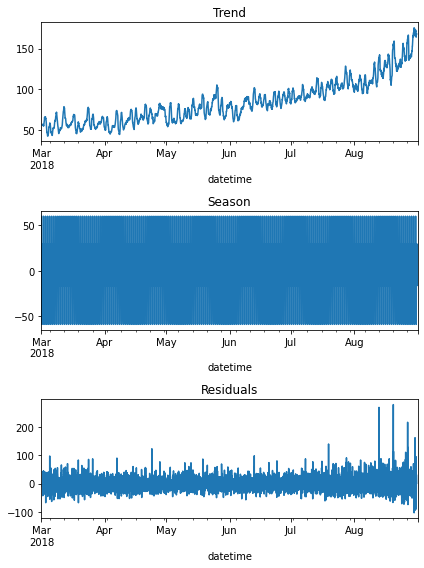

In [3]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Season')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')



plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='datetime'>

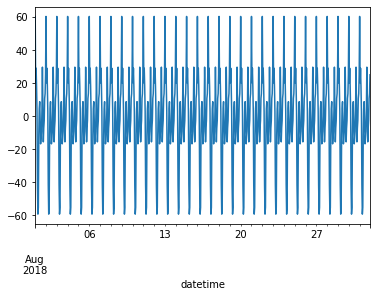

In [4]:
decomposed_1 = seasonal_decompose(data)
decomposed_1.seasonal['2018-08-01':'2018-08-31'].plot()

The trend chart shows that the number of orders is growing relatively systematically, while August showed the largest marginal growth. This may be due to the beginning of the "velvet season" and an increase in the inrush of tourists. The chart also shows that there are some “outliers” in August that are are explained by the trend.

No special seasonality is observed on the first charts. Therefore, a seasonality graph was separately constructed for a short interval (month - August). From this graph, it is clear that the number of orders has certain peaks and valleys associated with the time of the day. It seems that during the night the number of orders falls, increases during the day.

<AxesSubplot:xlabel='datetime'>

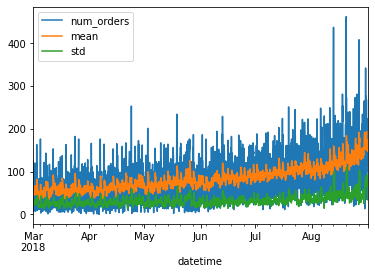

In [5]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

The chart above shows the moving average and standard deviation of the time series. These graphs are more stationary than the graph of the number of orders. At the same time, the moving average is also systematically growing. Below is the decomposition of the standard deviation.

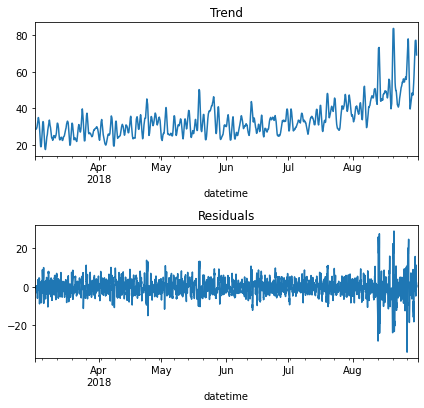

In [6]:
data_std = data['std']
data_std = data_std.dropna()
decomposed_std = seasonal_decompose(data_std)


plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed_std.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_std.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

The standard deviation has a more non-linear trend, all the months up to August do not differ much from each other. The standard deviation increases in August, both in relative and absolute terms. The moving average and deviation parameters will be used as features in the next step.

### Conclusion
Data analysis showed that the time series is not stationary - its mean and standard deviation change with time. At the same time, the prediction of 10% of the population (respectively, the "tails" of the time series) is complicated by the fact that the growth trend showed the largest jump in the last month. 

Deviations in the graphs may indicate that the load of drivers is non-linear - due to the fact that an unequal number of flights arrive every hour (and taxis to the airport are called upon the arrival or departure of an aircraft), for example, at night the load is much less. This was also confirmed by the seasonality plotted for August, which shows that orders have certain peaks and falls associated with the time of the day: during the night period, the number of orders falls, increases during the day. The increase in orders in August can be explained by the tourist season.

<a id='third'></a>
## 3. Training the model

Features will also include:
 - a lag of 7 days (a week) 
 - a moving average of 2 days 
 
The sample will be divided into training, validation and test in the proportion of 80:10:10.

In [7]:
def make_features(data, max_lag, rolling_size_mean):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['std'].shift(lag)
    data['rolling_size'] = data['std'].shift().rolling(rolling_size_mean).mean()  

In [8]:
data_features = data
make_features(data_features, 7, 2)
data_features.head()

,num_orders,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_size
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,1,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,1,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train_0, test = train_test_split(data_features, shuffle=False, test_size = 0.1)
train_0 = train_0.dropna()
train, valid = train_test_split(train_0, shuffle=False, test_size = 0.1)
display(train.shape)
display(valid.shape)
test.shape

(3557, 15)

(396, 15)

(442, 15)

In [10]:
features_train = train.drop('num_orders',1)
features_valid = valid.drop('num_orders',1)
features_test = test.drop('num_orders',1)

target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

#order of the data samples correctness check 
display(features_train.head(2))
display(features_train.tail(2))
display(features_valid.head(2))
display(features_valid.tail(2))
display(features_test.head(2))

,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_size
datetime,,,,,,,,,,,,,,
2018-03-01 21:00:00,52.400000,20.818261,3,1,3,21,22.866694,25.073796,25.079872,24.581836,25.510969,27.357074,33.353089,23.970245
2018-03-01 22:00:00,58.933333,23.453500,3,1,3,22,20.818261,22.866694,25.073796,25.079872,24.581836,25.510969,27.357074,21.842478


,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_size
datetime,,,,,,,,,,,,,,
2018-07-28 00:00:00,131.333333,41.150710,7,28,5,0,37.700322,39.003297,36.266211,37.016727,38.404241,37.997118,37.364613,38.351809
2018-07-28 01:00:00,134.400000,44.164951,7,28,5,1,41.150710,37.700322,39.003297,36.266211,37.016727,38.404241,37.997118,39.425516


,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_size
datetime,,,,,,,,,,,,,,
2018-07-28 02:00:00,136.733333,43.705944,7,28,5,2,44.164951,41.150710,37.700322,39.003297,36.266211,37.016727,38.404241,42.657830
2018-07-28 03:00:00,137.666667,43.425908,7,28,5,3,43.705944,44.164951,41.150710,37.700322,39.003297,36.266211,37.016727,43.935447


,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_size
datetime,,,,,,,,,,,,,,
2018-08-13 12:00:00,152.800000,96.752409,8,13,0,12,95.450561,96.584382,98.273428,99.898139,99.182852,94.720240,91.653748,96.017471
2018-08-13 13:00:00,152.866667,96.727058,8,13,0,13,96.752409,95.450561,96.584382,98.273428,99.898139,99.182852,94.720240,96.101485


,mean,std,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_size
datetime,,,,,,,,,,,,,,
2018-08-13 14:00:00,147.333333,97.130742,8,13,0,14,96.727058,96.752409,95.450561,96.584382,98.273428,99.898139,99.182852,96.739733
2018-08-13 15:00:00,148.333333,97.347439,8,13,0,15,97.130742,96.727058,96.752409,95.450561,96.584382,98.273428,99.898139,96.928900


In [11]:
def rmse(model): #metrics for the model check
    model.fit(features_train, target_train)
    pred_valid = model.predict(features_valid)
    return print('RMSE valid {}:'.format(model), mean_squared_error(target_valid, pred_valid, squared=False))

In [12]:
model_linear = LinearRegression()
rmse(model_linear)

RMSE valid LinearRegression(): 40.27828670466766


In [13]:
model_tree = DecisionTreeRegressor(max_depth=6)
rmse(model_tree)

RMSE valid DecisionTreeRegressor(max_depth=6): 30.95094429133381


In [14]:
model_forest = RandomForestRegressor(max_depth=12)
rmse(model_forest)

RMSE valid RandomForestRegressor(max_depth=12): 27.04218847225491


In [15]:
model_cat = CatBoostRegressor(loss_function='RMSE', iterations=100, verbose=5, max_depth=5, learning_rate=0.8)
rmse(model_cat)

0:	learn: 28.9282171	total: 49ms	remaining: 4.85s
5:	learn: 20.8616269	total: 57.9ms	remaining: 907ms
10:	learn: 18.8226255	total: 66.5ms	remaining: 538ms
15:	learn: 17.4732888	total: 75.1ms	remaining: 394ms
20:	learn: 16.4507739	total: 84.1ms	remaining: 316ms
25:	learn: 15.9106139	total: 93ms	remaining: 265ms
30:	learn: 15.3722078	total: 102ms	remaining: 227ms
35:	learn: 14.7407752	total: 110ms	remaining: 196ms
40:	learn: 14.3530834	total: 119ms	remaining: 172ms
45:	learn: 13.9083242	total: 128ms	remaining: 150ms
50:	learn: 13.4034423	total: 137ms	remaining: 131ms
55:	learn: 13.0043235	total: 145ms	remaining: 114ms
60:	learn: 12.6574274	total: 154ms	remaining: 98.5ms
65:	learn: 12.3811065	total: 163ms	remaining: 84.1ms
70:	learn: 12.1162765	total: 174ms	remaining: 70.9ms
75:	learn: 11.7624797	total: 183ms	remaining: 57.8ms
80:	learn: 11.5047770	total: 192ms	remaining: 45.1ms
85:	learn: 11.2336610	total: 202ms	remaining: 32.8ms
90:	learn: 11.0358921	total: 212ms	remaining: 20.9ms
95:	l

In [16]:
estimator = lgb.LGBMRegressor()

param_grid = { 
    "learning_rate": [0.05, 0.1, 0.5],
    "num_leaves": [50, 100, 200],
    "max_depth": [6, 8, 10]}

grid = GridSearchCV(estimator, param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit()) #TimeSeriesSplit to avoid shuffling
grid.fit(features_train, target_train)

print(grid.best_score_ , grid.best_params_)

-21.372053135909162 {'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 100}


In [17]:
model_lgbm = lgb.LGBMRegressor(learning_rate = 0.1, max_depth=6, num_leaves=100, random_state = 12345)
rmse(model_lgbm)

RMSE valid LGBMRegressor(max_depth=6, num_leaves=100, random_state=12345): 27.009204918173626


### Conclusion
The best RMSE score was shown by the LGBM model. It is proposed to train this model on a new training set, incl. validation data, since they are the closest in time to the test data and it will be useful for the model to be trained on them.

<a id='fourth'></a>
## 4. Test

In [18]:
features_train_final = train_0.drop('num_orders',1)
target_train_fianl = train_0['num_orders']
features_train_final.shape

(3953, 14)

In [19]:
model_lgbm_final = lgb.LGBMRegressor(learning_rate = 0.1, max_depth=6, num_leaves=100, random_state = 12345)
model_lgbm_final.fit(features_train_final, target_train_fianl)
pred_test = model_lgbm_final.predict(features_test)
print('RMSE test final', mean_squared_error(target_test, pred_test, squared=False))

RMSE test final 38.0322230648233


<AxesSubplot:xlabel='datetime'>

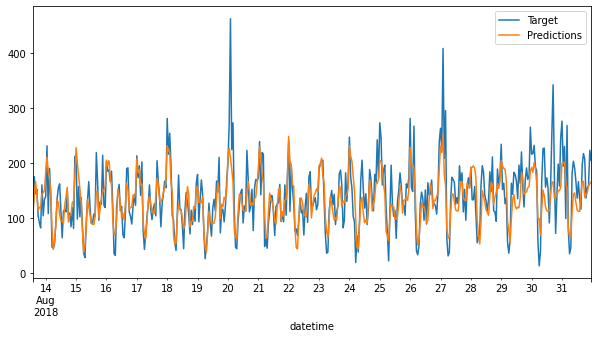

In [20]:
data_graph = pd.DataFrame(target_test)
data_graph.rename(columns = {'num_orders':'Target'}, inplace = True)
data_graph['Predictions'] = pred_test
data_graph.plot(figsize=(10, 5))

### Conclusion
The RMSE score on the test data is 38, which is in line with the task. The prediction graph follows the trend of the original values (targets). At the same time, strong outliers are visible on the graph, which the model could not predict accurately.

<a id='fifth'></a>
## 5. Summary

Thus, the data on the number of taxi orders from March to August 2018 was analyzed, a model that predicts the number of taxi orders per hour was trained and tested .

The number of taxi orders is growing relatively systematically during this period of time, with August showing the largest marginal growth. Such a jump can be explained by the tourist season. Also, the drivers' load is non-linear - which is explained by the fact that taxis to the airport are called upon the arrival or departure of an aircraft, and, for example, there are fewer flights at night.

LGBM Regressor was chosen as the model, with parameters: learning_rate **0.1**, depth **6**, number of leaves **100**. The RMSE metric on the test data is **38**, which corresponds to the task. Model was unable to predict certain data outliers.